# Projeto 2 - Árvores de Decisão

Para escrevermos um programa que dados vários datasets conseguisse implementar uma árvore de decisão usando o procedimento ID3, dividimos o problema em dois: 

- decisionTree.py
- main.py

## decisionTree.py

Este programa contém os métodos cruciais para a implementação de uma árvore de decisão através da criação da classe DecisionTree.

Vamos analisá-lo cuidadosamente:

Começamos por importar várias bibliotecas:

- math: para utilizar a função matemática log2, que é necessária para calcular a entropy
- collections: para utilizar a estrutura de dados Counter, que ajuda a contar a frequência de elementos em listas, útil na contagem de classes
- numpy: para uma manipulação eficiente de arrays e operações numéricas
- pandas: para a manipulação e transformação de dados (leitura de CSVs, processamento de colunas, discretização de valores numéricos).
- argparse: para permitir que o ficheiro aceite e processe argumentos da linha de comando

Nota: as bibliotecas pandas e argparse são necessárias apenas no ficheiro main.py.

In [1]:
from math import log2
from collections import Counter
import numpy as np
import pandas as pd
from argparse import ArgumentParser
import sys

De seguida definimos a classe DecisionTree. 

O método __ __init__ __ é o método de inicialização da classe. Recebe um argumento, dataset, que é o conjunto de dados utilizado para construir a árvore de decisão.

In [2]:
class DecisionTree:
    def __init__(self, dataset):
        dataset = self.bool_to_string(dataset)
        attributes = dataset.columns.tolist()[1:-1]
        self.tree = self.id3(dataset, dataset, attributes)

De seguida, definimos o método __predict__ que serve para fazer previsões usando a árvore que foi construída. É aplicada uma função lambda a cada linha do dataset. Esta função chama o método __tracing__ da classe, passando a árvore de decisão (_self.tree_) e a linha atual (_row_). O método __tracing__ é responsável por percorrer a árvore de decisão para determinar a classe prevista para cada linha (já o vamos analisar). 
Logo, após percorrer cada linha do conjunto de dados de entrada e utilizar a árvore de decisão para prever a classe para cada linha, é retornada uma lista __pred__ com as previsões.

In [3]:
    def predict(self, dataset):
        pred = dataset.apply(lambda row: self.tracing(self.tree, row), axis=1)
        pred = pred.apply(lambda pred: pred[0] if pred is not None else pred)
        
        return pred.tolist()

O método __best_split_val__ percorre todos os valores únicos do atributo dado, calcula o ganho de informação para cada valor possível  de divisão, e retorna o valor que maximiza o ganho de informação, ajudando na construção eficaz da árvore de decisão.

-> Raciocínio

O argumento __data__ é o conjunto de dados atual e o argumento __attribute__ é o nome do atributo para o qual se deseja encontrar o melhor valor de divisão.
Primeiro são obtidos os valores únicos do atributo especificado (__attr__) e são inicializadas as variáveis __split_val__ como _None_ e __best_information_gain_ como _-infinito_, indicando que qualquer ganho de informação será maior que este valor inicial. 
Se __attr__ tiver apenas um valor único, é retornado esse valor, já que não há divisão possível para maximizar o ganho de informação.
Se esse não for o caso entramos num ciclo for que começa por criar dois subconjuntos: __subset1__ com linhas onde o valor de __attr__ é menor ou igual a __val__ e __subset2__ com linhas onde o valor de __attr__ é maior que __val__. De seguida, obtemos as listas das classes alvo correspondentes aos dois subconjuntos (__target1__ e __target2__).
Finalmente podemos calcular o ganho de informação resultante da divisão dos dados em __target1__ e __target2__. O método __gain__ calcula quanto a incerteza (entropy) diminui ao fazer essa divisão.
Se o ganho de informação calculado for maior que o melhor ganho de informação encontrado até agora (__best_information_gain__), atualiza __best_information_gain__ e define __split_val__ como o valor atual val.
É retornado o valor de divisão __split_val__ que proporciona o maior ganho de informação.

In [4]:
    def best_split_val(self, data, attribute):
        attr = data[attribute].unique()
        split_val = None
        best_information_gain = float('-inf')

        if len(attr) == 1:
            return attr[0]

        for val in attr:
            subset1 = data[data[attribute] <= val]
            subset2 = data[data[attribute] > val]

            target1 = subset1[data.columns[-1]].tolist()
            target2 = subset2[data.columns[-1]].tolist()

            information_gain = self.gain(data[data.columns[-1]].tolist(), target1, target2)

            if information_gain > best_information_gain:
                best_information_gain = information_gain
                split_val = val

        return split_val

O método __tracing__ percorre recursivamente a árvore até encontrar uma folha para prever a classe de uma linha de dados específica.

-> Raciocínio

Primeiro temos de obter o próximo atributo da árvore e o valor correspondente da sua linha e converter quaisquer desses valores booleanos para strings.
Depois verificamos se a subárvore é um dicionário (o que indica que não é uma folha) e obtemos a chave e valor para a divisão. 
Daí convertemos o valor para um número e decidimos a próxima subárvore com base nas condições <= ou >.
Se a próxima subárvore ainda for um dicionário, chamamos recursivamente o método __tracing__. Caso contrário, retornamos a classe prevista.

In [5]:
    def tracing(self, tree, row):
        attr = next(iter(tree))
        val = row[attr]

        if isinstance(val, bool):
            val = str(val)

        if isinstance(tree[attr], dict):
            split_key, split_val = next(iter(tree[attr])).split(' ')
            try:
                numeric_val = float(val)
                if split_key == '<=':
                    next_subtree = tree[attr]['<= ' + split_val] if numeric_val <= float(split_val) else tree[attr]['> ' + split_val]
                elif split_key == '>':
                    next_subtree = tree[attr]['> ' + split_val] if numeric_val > float(split_val) else tree[attr]['<= ' + split_val]
                else:
                    return None
            except ValueError:
                return None
        else:
            next_subtree = tree[attr][val]

        if isinstance(next_subtree, dict):
            return self.tracing(next_subtree, row)
        else:
            return next_subtree


O método __id3__ implementa o algoritmo ID3, construindo recursivamente uma árvore de decisão através desse mesmo algoritmo.

-> Raciocínio

1. Inicialização e Casos Base
   - Primeiro, temos de obter a lista das classes alvo (__target__)
   - De seguida, contamos a frequência de cada classe em __target__
   - se todas as instâncias tiverem a mesma classe, retornamos essa classe e a sua contagem
   - se não houverem mais atributos para dividir, retornamos a classe mais comum e a contagem total.
2. Encontrar melhor atributo
   - determinamos o melhor atributo para dividir os dados usando __self.best_attribute__ e criamos um nó na árvore para esse atributo
3. Dividir Dados (Atributo numérico)
   - se o melhor atributo for numérico,encontramos o melhor valor de divisão (__split_val__) e dividimos os dados em subconjuntos baseados nas condições <= ou >
   - removemos o atributo atual dos atributos restantes
   - Por fim, chamamos recursivamente __id3__ para os subconjuntos, adicionando o resultado ao nó
4. Dividir Dados (Atributo Categórico)
   - para atributos categóricos, iteramos sobre os valores únicos do melhor atributo
   - de seguida, criamos subconjuntos para cada valor
   - se um subconjunto estiver vazio, adicionamos à classe mais comum
   - caso contrário, removemos o atributo atual dos atributos restantes e chamamos __id3__ recursivamente
5. Retornar Nó
   - Finalmente, retornamos o nó construído, que pode ser um atributo com as suas subdivisões ou uma classe final

In [6]:
    def id3(self, dataset, data, attributes):
        target = data[data.columns[-1]].tolist()
        counters = Counter(target)

        if len(set(target)) == 1:
            return [target[0], counters[target[0]]]
        if len(attributes) == 0:
            return [counters.most_common(1)[0][0], len(target)]

        best = self.best_attribute(data, attributes)
        node = {best: {}}

        if data[best].dtype in ('int64', 'float64'):
            split_val = self.best_split_val(data, best)
            for operator, subset_condition in [('<=', data[best] <= split_val),('>', data[best] > split_val)]:
                subset = data[subset_condition]
                remaining_attributes = attributes.copy()
                remaining_attributes.remove(best)
                node[best][f'{operator} {split_val}'] = self.id3(dataset, subset, remaining_attributes)
        else:
            for val in dataset[best].unique():
                subset = data[data[best] == val]
                if len(subset) == 0:
                    node[best][val] = [counters.most_common(1)[0][0], 0]
                else:
                    remaining_attributes = attributes.copy()
                    remaining_attributes.remove(best)
                    node[best][val] = self.id3(dataset, subset, remaining_attributes)

        return node

O método __calc_entropy__ é um método estático que calcula a entropy de um conjunto de valores alvo (_target_). A entropy é uma medida da incerteza ou impureza num conjunto de dados.
Esta é calculada usando a fórmula: 

entropy = −∑ (n,i=1): pi x log2 (pi) , onde pi é a probabilidade do valor i no conjunto de dados.

Objetivo: 
No contexto das árvores de decisão, é usada para determinar o melhor atributo para dividir os dados em cada nó, com o objetivo de minimizar a incerteza (entropy) após a divisão.

Passos:
1. Contar as ocorrências de cada classe (_counters_)
2. Calcular a probabilidade de cada classe (_prob_)
3. Usar essas probabilidades para calcular a entropy com implementação da fórmula através de um ciclo for (_entropy_)


In [7]:
    @staticmethod
    def calc_entropy(target):
        counters = Counter(target)
        total = len(target)
        entropy = 0

        for c in counters.values():
            prob = c / total
            entropy -= prob * log2(prob)

        return entropy

O método __attr_entropy__ calcula a entropy ponderada de um determinado atributo no conjunto de dados. Essa entropy ponderada ajuda a determinar a qualidade da divisão dos dados com base nesse atributo.

entropy_attribute = ∑ (i=1,k): ((∣D∣/∣D∣i) x entropy(Di)) , onde ∣D∣i é o tamanho do subconjunto i onde o atributo tem um valor específico; ∣D∣ é o tamanho total do conjunto de dados; entropy(∣D∣i) é a entropy do subconjunto Di através do método __calc_entropy__

Objetivo: 
Calcular a entropy ponderada de um atributo para determinar quão bem ela divide o conjunto de dados. Quanto menor é a entropy, melhor é a divisão.

Passos:
1. Iterar sobre cada valor único do atributo (_attr_)
ciclo for:
2. Criar subconjuntos de dados para cada valor
3. Calcular a entropy de cada subconjunto
4. Ponderar a entropy pelo tamanho relativo do subconjunto
5. Somar as entropys ponderadas para obter a entropy total do atributo

In [8]:
    def attr_entropy(self, data, attribute):
        attr = data[attribute].unique()
        entropy_attribute = 0

        for val in attr:
            subset = data[data[attribute] == val]
            subset_target = subset[data.columns[-1]].tolist()
            subset_entropy = self.calc_entropy(subset_target)
            subset_prob = len(subset_target) / len(data)
            entropy_attribute += subset_prob * subset_entropy

        return entropy_attribute

O método __best_attribute__ determina qual o melhor atributo para dividir os dados, com base no ganho de informação. 
Ele encontra o atributo que maximiza o ganho de informação, que é a diferença entre a entropy da coluna alvo e a entropy ponderada do atributo, com a fórmula seguinte: 

Information Gain = Entropy(Target)−Entropy(Attribute)

Objetivo: Identificar o melhor atributo para dividir os dados, maximizando a redução de incerteza (ganho de informação).

Passos:
1. Calcula a entropy da coluna alvo (_target_entropy_)
2. Itera sobre cada atributo, calculando a sua entropy ponderada e o ganho de informação (ciclo for)
3. Encontra o índice do maior ganho de informação na lista __information_gains__ (_best_attribute_index_)
4. Retorna o atributo correspondente a esse índice na lista __attributes__


In [9]:
    def best_attribute(self, data, attributes):
        target_entropy = self.calc_entropy(data[data.columns[-1]].tolist())
        information_gains = []

        for attr in attributes:
            entropy_attribute = self.attr_entropy(data, attr)
            information_gain = target_entropy - entropy_attribute
            information_gains.append(information_gain)

        best_attribute_index = information_gains.index(max(information_gains))
        return attributes[best_attribute_index]

O método __gain__ avalia a qualidade de uma divisão dos dados em termos de redução de incerteza. O ganho de informação mede a diferença entre a entropy do conjunto original e a soma das entropys ponderadas dos subconjuntos resultantes.

1. Calcular a entropy do conjunto de dados pai (_total_)
2. Calcular as proporções dos dois subconjuntos (_weight1_ , _weight2_)
3. Calcular as entropys dos dois subconjuntos (_entropy1_ , _entropy2_)
4. Calcular o ganho de informação subtraindo as entropys ponderadas dos subconjuntos da entropy do conjunto pai (_information_gain_)

-> Este método é essencial para determinar a eficácia de uma divisão de dados, contribuindo para a construção de uma árvore de decisão o mais eficiente possível.

In [10]:
    def gain(self, parent_target, target1, target2):
        parent_entropy = self.calc_entropy(parent_target)
        
        total = len(parent_target)
        weight1 = len(target1) / total
        weight2 = len(target2) / total
        
        entropy1 = self.calc_entropy(target1)
        entropy2 = self.calc_entropy(target2)
        
        information_gain = parent_entropy - (weight1 * entropy1) - (weight2 * entropy2)
        
        return information_gain

O método __ __str__ __ define o comportamento da conversão de uma instância da classe para um String. Neste caso, ele usa o método __tree_to_string__ para converter a árvore de decisão (_self.tree_) numa representação de String.

In [11]:
    def __str__(self):
        return self.tree_to_string(self.tree)

O método __tree_to_string__ percorre a árvore de decisão recursivamente, construindo uma representação em String que mostra a hierarquia dos nós e as condições de divisão. 
A indentação (_indent_) é usada para representar a profundidade dos nós na árvore, e o contador (_counter_) é usado para rastrear o número de nós.

Objetivo: Converter a árvore de decisão num String legível, mostrando a estrutura hierárquica da árvore.

Passos:

1. Inicializar a árvore se não for fornecida (_t_)
2. Tratar dos nós filhos diretamente 
3. Iterar sobre os nós internos, chamando a função recursivamente para as subárvores (ciclo for)
4. Usar indentação para mostrar a profundidade da árvore e um contador para numerar os nós 

Esta função é chamada pelo método __str__, permitindo que a árvore de decisão seja impressa ou convertida num String de forma legível.


In [12]:
    def tree_to_string(self, t=None, indent='', counter=1):
        if t is None:
            t = self.tree

        result = ""
        if not isinstance(t, dict):
            result += f"{indent}{t[0]} (counter{counter} = {t[1]})\n"
            return result

        for attribute, subtree in t.items():
            result += f"{indent}<{attribute}>\n"
            for val, subsubtree in subtree.items():
                result += f"{indent}    {val}:\n"
                if isinstance(subsubtree, dict):
                    result += self.tree_to_string(subsubtree, indent + '        ', counter)
                else:
                    result += f"{indent}        {subsubtree[0]} (counter{counter} = {subsubtree[1]})\n"
                counter += 1
        return result

O método __bool_to_string__ percorre o conjunto de dados e converte todas as colunas booleanas em colunas de Strings, onde _True_ se torna _'True'_ e _False_ se torna _'False'_. 

Passos:
1. Selecionar as colunas booleanas do conjunto de dados (_boolean_columns_)
2. Converter os valores booleanos (True/False) em strings ('True'/'False') (ciclo for)
3. Retornar o conjunto de dados processado (_dataset_)

Este método é útil para garantir que todas as colunas do conjunto de dados estejam no formato de String, o que pode ser necessário para certas operações ou algoritmos que não aceitem valores booleanos.

In [13]:
    @staticmethod
    def bool_to_string(dataset):
        boolean_columns = dataset.select_dtypes(include=bool).columns

        for column in boolean_columns:
            dataset[column] = dataset[column].map({False: 'False', True: 'True'})

        return dataset

O método __accuracy__ mede a precisão das previsões, que é a proporção de previsões corretas.A fórmula para a precisão é:

Accuracy = Número de precisões certas (_correct_) / Número total de precisões (_len(y_true)_)

Este método é útil para avaliar o desempenho de um modelo de classificação.

In [14]:
    @staticmethod
    def accuracy(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        correct = np.sum(y_true == y_pred)
        return correct / len(y_true)

## main.py

Este ficheiro contém mais essencialmente os módulos utilizados para correr o programa e imprimir a árvore de decisão desejada.

Ele lê conjuntos de dados de treino e teste (_dataset.csv_), treina uma árvore de decisão usando o conjunto de dados de treino, e faz previsões no conjunto de dados de teste, calculando a precisão das previsões. As bibliotecas pandas e argparse são essenciais para manipulação de dados e para criar uma interface de linha de comando flexível, respectivamente.

Vamos analisá-lo mais detalhadamente:

Método __preprocess_connect4_dataset__

Este método foi implementado propositadamente para a melhor configuração do dataset _connect4.csv_. Como requerido no inunciado deste projeto tivemos de implementar um método que processasse este dataset adicionando os nomes de colunas e uma coluna de identificação (ID) (header).

Passos:
1. Ler o arquivo CSV sem cabeçalhos (header=None) e definir os nomes das colunas. (_column_names_ , _data_)
2. Adicionar uma coluna ID com valores sequenciais de 1 até o número de linhas no dataset (_data.insert(0, 'ID', range(1, len(data) + 1))_)


Método __discretize_numeric_values__

Para datasets como a iris.csv e weather.csv, que contêm valores numéricos tivemos de implementar uma maneira para discretizar esses valores, de modo a minimizar o tamanho da árvore. Para tal implementamos o método __discretize_numeric_values__. 
Ele itera primeiramente sobre cada coluna numérica no dataset e usa depois __pd.cut__ para dividir os valores em 3 intervalos e rotula-os como _low_, _medium_ e _high_.
Por exemplo, para o Dataset __weather.csv__ obtivemos os seguintes valores:
low = 70, medium < 90 e > 70, high >= 90


Método principal __main__

Este método tem como objetivos, configurar e analisar argumentos da linha de comando; a leitura e processamento de um dataset de treino e um de teste; por fim e mais importante, é este método que finalmente imprime a árvore de decisão desejada.

In [15]:
#import pandas as pd
#import numpy as np
#from argparse import ArgumentParser
#from decisionTree import DecisionTree

def preprocess_connect4_dataset(filename):
    column_names = [f'col_{i}' for i in range(1, 43)] + ['Class']
    data = pd.read_csv(filename, header=None, names=column_names)
    data.insert(0, 'ID', range(1, len(data) + 1))
    return data

def discretize_numeric_values(dataset):
    for col in dataset.select_dtypes(include=[np.number]).columns:
        dataset[col] = pd.cut(dataset[col], bins=3, labels=['low', 'medium', 'high'])
    return dataset

def main():
    parser = ArgumentParser(description='Decision Tree')
    parser.add_argument('-tr', '--train', required=True, help='Dataset que vai ser usado para treinar a Decision Tree')
    parser.add_argument('-t', '--test', help='Dataset que vai ser usado para testar a Decision Tree')

    args = parser.parse_args()

    try:
        dataset_path = args.train
        dataset = pd.read_csv(dataset_path, na_values=['NaN'], keep_default_na=False)
        if args.train == 'connect4.csv':
            dataset = preprocess_connect4_dataset(dataset_path)
        if 'ID' in dataset.columns:
            dataset = dataset.drop(columns=['ID'])
        dataset = discretize_numeric_values(dataset)
        print("A treinar o classificador da decision tree no '" + str(args.train) + "' dataset:\n")
        tree = DecisionTree(dataset)
        print(tree)
    except FileNotFoundError:
        print("O dataset '" + str(args.train) + "' não existe.")
        exit()

    if args.test:
        try:
            test_path = args.test
            test_dataset = pd.read_csv(test_path, na_values=['NaN'], keep_default_na=False)
            if 'ID' in test_dataset.columns:
                test_dataset = test_dataset.drop(columns=['ID'])
            print("A prever os valores para o'" + str(args.test) + "' dataset:\n")
            pred = tree.predict(test_dataset)
            print(pred)

            true_labels = test_dataset[test_dataset.columns[-1]].tolist()

            accuracy = DecisionTree.accuracy(true_labels, pred)
            print(f"Accuracy: {accuracy:.2f}")


        except FileNotFoundError:
            print("O dataset '" + str(args.test) + "' não esxite.")

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] -tr TRAIN [-t TEST]
ipykernel_launcher.py: error: the following arguments are required: -tr/--train


SystemExit: 2

/home/ana/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Outputs

O JupyterLab não consegue executar diretamente programas que requerem interatividade da linha de comando como aqueles que utilizam argparse para analisar argumentos da linha de comando (o que é o nosso caso). 

Logo, ficam aqui os outputs que obtemos ao correr os datasets que nos foram dados: 

__Dataset: Restaurant__


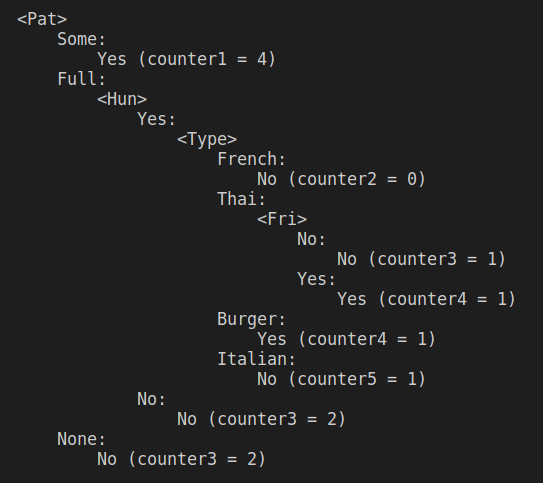


__Dataset: Weather__


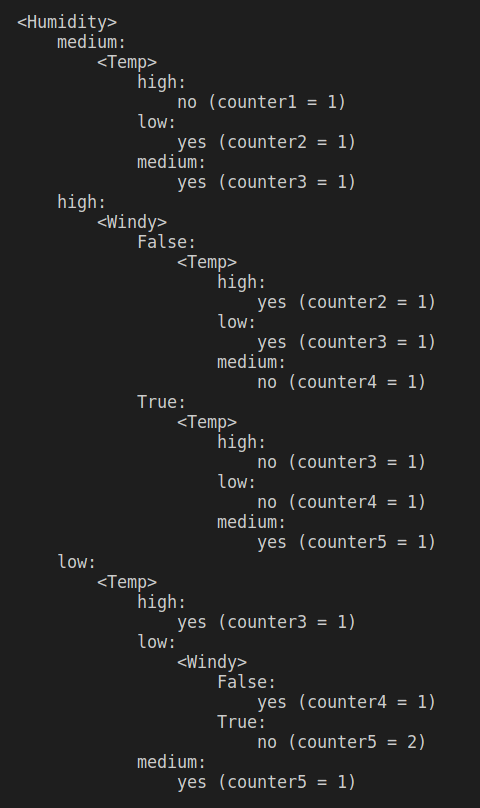

__Dataset: Iris__


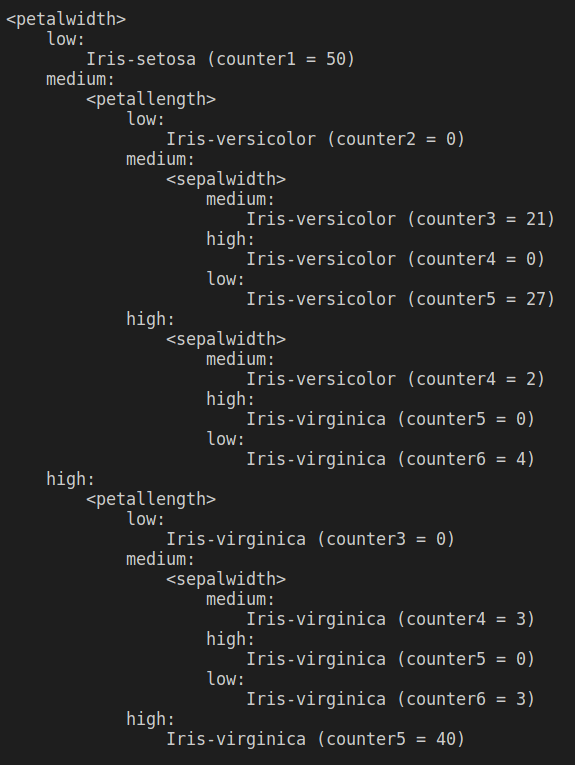

__Dataset: Connect4__ (Colocamos apenas um exerto do código, porque era demasiado grande.)


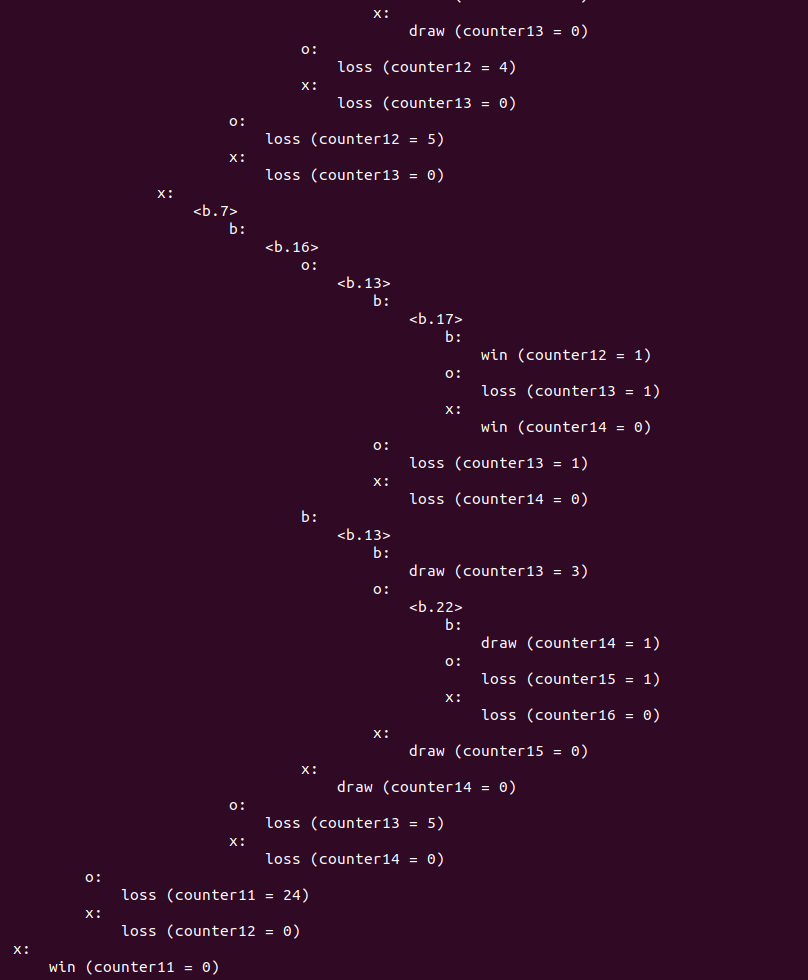